In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from typing import Tuple
import torch.nn.functional as F
import random
import pickle
import time
import numpy as np

DTYPE = torch.float

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
# DUMP_FILE_NAME = '/tmp/data/fed-data.pkl'
DUMP_FILE_NAME = '/tmp/data/fed-data-IID.pkl'

NUM_OUTPUTS = 10

loader_g = torch.Generator()
loader_g.manual_seed(2023)


# Define VGG block
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)]
        in_channels = out_channels
    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)

# Define the VGG11bn model
class VGG11bn(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11bn, self).__init__()
        self.features = nn.Sequential(
            vgg_block(1, 3, 64),
            vgg_block(1, 64, 128),
            vgg_block(2, 128, 256),
            vgg_block(2, 256, 512),
            vgg_block(2, 512, 512),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465), 
        (0.2023, 0.1994, 0.2010))
])

criterion = nn.CrossEntropyLoss()


# Define Network
def load_model():
    return VGG11bn(num_classes=NUM_OUTPUTS)


def load_train_data(dataset):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.RandomSampler(dataset, generator=loader_g),
        drop_last=True
    )

def load_val_data(dataset):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SequentialSampler(dataset),
        drop_last=True
    )

def load_client_data(node_id: int):
    """Load partition CIFAR10 data."""
    with open(DUMP_FILE_NAME, 'rb') as file:
        # Load the data from the file
        trainsets, valsets, _ = pickle.load(file)

    return load_train_data(trainsets[node_id]), load_val_data(valsets[node_id])

def load_test_data():
    """Load test CIFAR10 data."""
    with open(DUMP_FILE_NAME, 'rb') as file:
        # Load the data from the file
        _, _, testset = pickle.load(file)

    return load_val_data(testset)



def train(model, optimizer, trainloader, device, epoch):
    model.train()
    train_loss = 0.0
    num_processed_samples = 0
    start_time = time.time()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        batch_size = labels.shape[0]
        num_processed_samples += batch_size

    print(f'Train: train_loss={train_loss/len(trainloader):.6f}, samples/s={num_processed_samples / (time.time() - start_time):.3f}')


def test(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    loss = 0

    num_processed_samples = 0
    start_time = time.time()
    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            loss += criterion(outputs, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_size = labels.shape[0]
            num_processed_samples += batch_size

    test_acc = 100 * correct / total
    test_loss = float(loss / len(data_loader))

    print(f'Test: test_acc={test_acc:.3f}, test_loss={test_loss:.6f}, samples/s={num_processed_samples / (time.time() - start_time):.3f}')
    return test_loss, test_acc

In [8]:
def train_wo_noise():
    DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    
    print("Centralized PyTorch training")
    print("Load data")
    trainloader, testloader = load_client_data(0)
    net = load_model().to(DEVICE)
    net.eval()
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.0)

    hist = []
    for epoch in range(20):
        print(epoch)
        train(model=net, optimizer=optimizer, trainloader=trainloader, device=DEVICE, epoch=1)
        loss, accuracy = test(model=net, data_loader=testloader, device=DEVICE)
        print(f"Loss: {loss}, Accuracy: {accuracy}")
        hist.append((loss, accuracy))
    return hist


wo_noise_hist = train_wo_noise()


Centralized PyTorch training
Load data
0
Train: train_loss=2.237281, samples/s=2295.063
Test: test_acc=19.984, test_loss=2.016664, samples/s=3964.679
Loss: 2.0166642665863037, Accuracy: 19.98355263157895
1
Train: train_loss=1.985850, samples/s=2193.889
Test: test_acc=22.122, test_loss=2.017646, samples/s=3413.495
Loss: 2.017646074295044, Accuracy: 22.12171052631579
2
Train: train_loss=1.923823, samples/s=1975.634
Test: test_acc=25.576, test_loss=1.976890, samples/s=3348.563
Loss: 1.976890206336975, Accuracy: 25.575657894736842
3
Train: train_loss=1.850800, samples/s=1918.858
Test: test_acc=26.069, test_loss=1.760510, samples/s=3435.439
Loss: 1.7605103254318237, Accuracy: 26.06907894736842
4
Train: train_loss=1.780256, samples/s=2056.388
Test: test_acc=26.727, test_loss=1.811534, samples/s=3404.613
Loss: 1.8115342855453491, Accuracy: 26.726973684210527
5
Train: train_loss=1.750337, samples/s=1805.184
Test: test_acc=31.086, test_loss=1.747811, samples/s=3646.778
Loss: 1.747811198234558, 

In [29]:
def add_noise_to_model(model, device, mean=0, std=0.015):
    with torch.no_grad():
        for param in model.parameters():
            param.add_(torch.randn(param.size()).to(device) * std + mean)


def train_w_noise(mean=0, std=0):
    DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    
    print("Centralized PyTorch training")
    print("Load data")
    trainloader, testloader = load_client_data(0)
    net = load_model().to(DEVICE)
    net.eval()
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.0)

    training_record = []
    for epoch in range(20):
        print(epoch)
        add_noise_to_model(net, DEVICE, mean, std)
        train(model=net, optimizer=optimizer, trainloader=trainloader, device=DEVICE, epoch=1)
        loss, accuracy = test(model=net, data_loader=testloader, device=DEVICE)
        print(f"Loss: {loss}, Accuracy: {accuracy}")
        training_record.append((loss, accuracy))
    return training_record


w_noise_hist_2 = train_w_noise(mean=0, std=0)

Centralized PyTorch training
Load data
0
Train: train_loss=2.608777, samples/s=2490.027
Test: test_acc=16.941, test_loss=2.184040, samples/s=4132.751
Loss: 2.184039831161499, Accuracy: 16.94078947368421
1
Train: train_loss=2.105548, samples/s=2503.693
Test: test_acc=22.286, test_loss=1.980438, samples/s=4142.687
Loss: 1.980438470840454, Accuracy: 22.286184210526315
2
Train: train_loss=2.031574, samples/s=2501.038
Test: test_acc=21.135, test_loss=2.039179, samples/s=4144.579
Loss: 2.0391786098480225, Accuracy: 21.13486842105263
3
Train: train_loss=1.964840, samples/s=2491.900
Test: test_acc=25.987, test_loss=1.854600, samples/s=4135.938
Loss: 1.8545998334884644, Accuracy: 25.986842105263158
4
Train: train_loss=1.959435, samples/s=2507.550
Test: test_acc=27.220, test_loss=1.816225, samples/s=4089.048
Loss: 1.8162248134613037, Accuracy: 27.220394736842106
5
Train: train_loss=1.882522, samples/s=2499.449
Test: test_acc=34.128, test_loss=1.733126, samples/s=4015.382
Loss: 1.7331258058547974

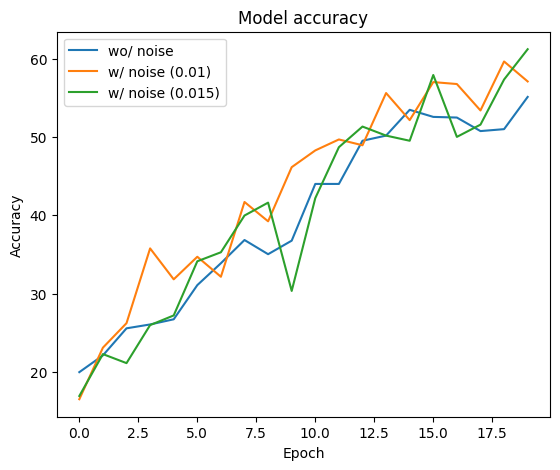

In [30]:
import matplotlib.pyplot as plt

# Assuming history is your model's history object containing 'loss', 'accuracy', 'val_loss', and 'val_accuracy' metrics

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot([item[1] for item in wo_noise_hist], label='wo/ noise')
plt.plot([item[1] for item in w_noise_hist], label='w/ noise (0.01)')
plt.plot([item[1] for item in w_noise_hist_2], label='w/ noise (0.015)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history['loss'], label='Train')
# if 'val_loss' in history:
#     plt.plot(history['val_loss'], label='Validation')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

plt.show()
